In [9]:
# Execute this code block to install dependencies when running on colab
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

try: 
    import torchbearer
except:
    !pip install torchbearer

In [4]:
! pip install wget

In [9]:
import wget
from os.path import exists

if not exists('data'):
    url = 'https://artist-cloud.ecs.soton.ac.uk/index.php/s/eAhIkhhdxgmhRHj/download'
    filename = wget.download(url, out='boat-data.zip')
#     !unzip boat-data.zip

100% [......................................................................] 266343621 / 266343621

In [10]:
import zipfile

with zipfile.ZipFile('boat-data.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

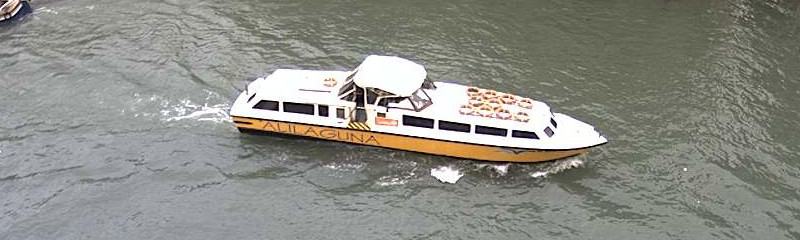

In [2]:
from IPython.display import Image
Image('data/test/Alilaguna/20130412_064059_20202.jpg')

In [1]:
%matplotlib inline

# Plot ad-hoc data instances
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

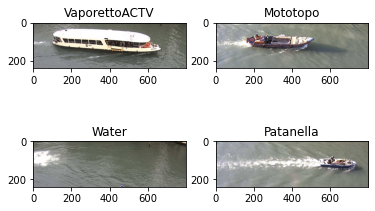

In [2]:
transform = transforms.Compose([
    transforms.Resize((240, 800)),
    transforms.ToTensor()
])

train_dataset = ImageFolder('data/train', transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# generate the first batch
(batch_images, batch_labels) = train_loader.__iter__().__next__()

# plot 4 images
plt.subplot(221).set_title(train_dataset.classes[batch_labels[0]])
plt.imshow(batch_images[0].permute(1, 2, 0), aspect='equal')

plt.subplot(222).set_title(train_dataset.classes[batch_labels[1]])
plt.imshow(batch_images[1].permute(1, 2, 0), aspect='equal')

plt.subplot(223).set_title(train_dataset.classes[batch_labels[2]])
plt.imshow(batch_images[2].permute(1, 2, 0), aspect='equal')

plt.subplot(224).set_title(train_dataset.classes[batch_labels[3]])
plt.imshow(batch_images[3].permute(1, 2, 0), aspect='equal')

plt.show()

## Simple CNN for Boat Classification

In [11]:
# the no. of images that will be processed in a single step
batch_size = 128

# the size of the images that we'll learn on 
# (we'll shrink them from the original size for speed)
image_size = (30, 100)

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()
])

train_dataset = ImageFolder('data/train', transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = ImageFolder('data/train', transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = ImageFolder('data/test', transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [23]:
import torch
import torch.nn.functional as F
from torch import nn

In [24]:
class BetterCNN(nn.Module):
    def __init__(self, n_channels_in, n_classes):
        super(BetterCNN, self).__init__()
        self.conv1 = nn.Conv2d(n_channels_in, 30, (5, 5), padding=0)
        self.conv2 = nn.Conv2d(30, 15, (3, 3), padding=0)
        self.fc1 = nn.Linear(1725, 128)
        self.fc2 = nn.Linear(128, 50)
        self.fc3 = nn.Linear(50, n_classes)
        
    def forward(self, x):
        out = self.conv1(x).relu()
        out = F.max_pool2d(out, (2, 2))
        out = self.conv2(out).relu()
        out = F.max_pool2d(out, (2, 2))
        out = F.dropout(out, 0.2)
        out = out.view(out.shape[0], -1)
        
        out = self.fc1(out).relu()
        out = self.fc2(out).relu()
        out = self.fc3(out)
        return out

In [25]:
import torchbearer
from torchbearer import Trial
from torch import optim
from torchbearer.callbacks import LiveLossPlot

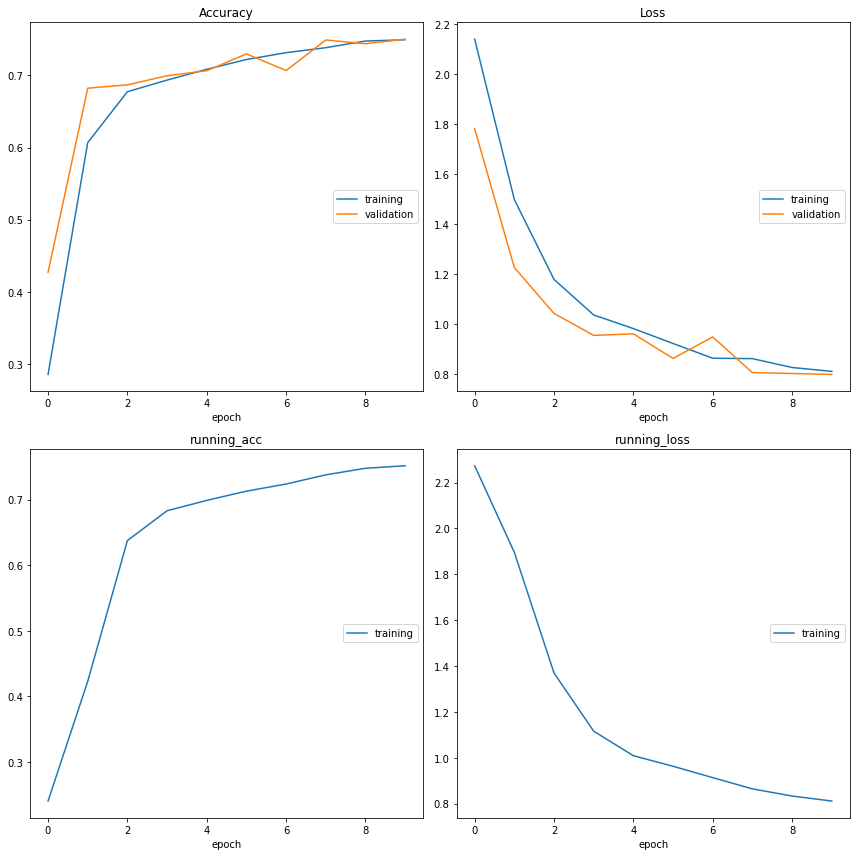

[{'running_loss': 2.272966146469116,
  'running_acc': 0.2406994104385376,
  'loss': 2.1403229236602783,
  'acc': 0.2855498194694519,
  'val_loss': 1.7819859981536865,
  'val_acc': 0.42717328667640686,
  'train_steps': 28,
  'validation_steps': 28},
 {'running_loss': 1.8955833911895752,
  'running_acc': 0.42304423451423645,
  'loss': 1.4978352785110474,
  'acc': 0.6067933440208435,
  'val_loss': 1.2252438068389893,
  'val_acc': 0.6822107434272766,
  'train_steps': 28,
  'validation_steps': 28},
 {'running_loss': 1.3696787357330322,
  'running_acc': 0.6374478936195374,
  'loss': 1.177868127822876,
  'acc': 0.6773172616958618,
  'val_loss': 1.0415453910827637,
  'val_acc': 0.686816394329071,
  'train_steps': 28,
  'validation_steps': 28},
 {'running_loss': 1.1159074306488037,
  'running_acc': 0.6828818917274475,
  'loss': 1.0354102849960327,
  'acc': 0.6934369802474976,
  'val_loss': 0.9535767436027527,
  'val_acc': 0.6994819045066833,
  'train_steps': 28,
  'validation_steps': 28},
 {'ru

In [26]:
model = BetterCNN(3, len(train_dataset.classes))

loss_function = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trial = Trial(model, optimiser, loss_function,
              metrics=['loss', 'accuracy'],
              callbacks=[LiveLossPlot()]).to(device)
trial.with_generators(train_loader, 
                      val_generator=val_loader,
                      test_generator=test_loader)
trial.run(epochs=10)

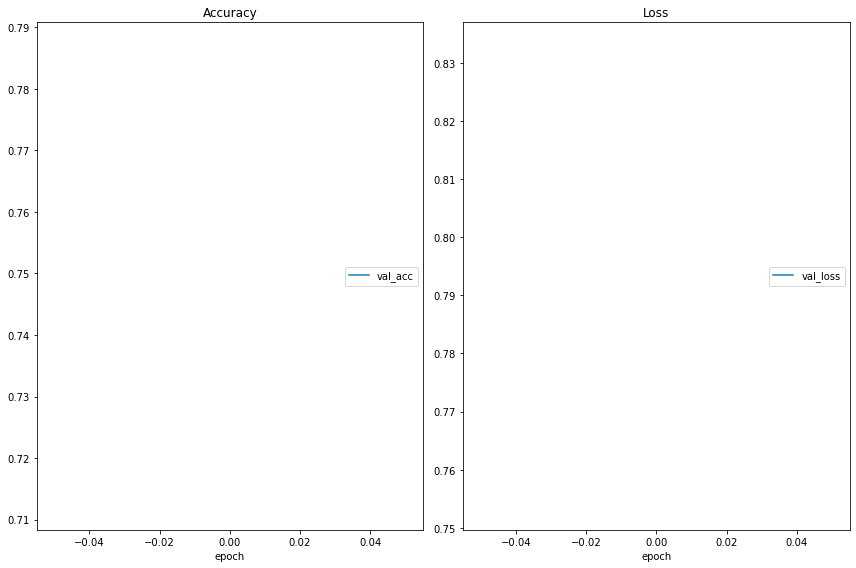


{'val_loss': 0.7933083772659302, 'val_acc': 0.7495682239532471}


In [28]:
results = trial.evaluate(data_key=torchbearer.VALIDATION_DATA)
print()
print(results)

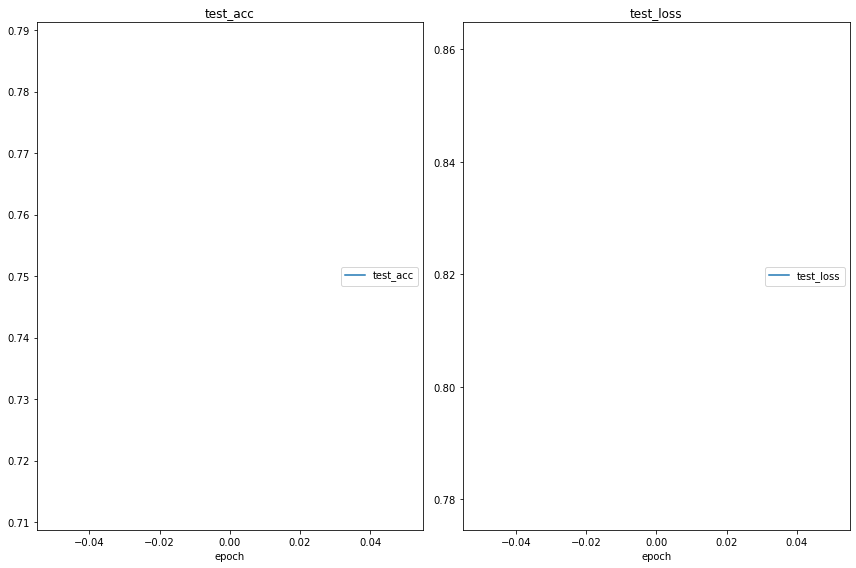

In [33]:
predictions = trial.predict()
predicted_classes = predictions.argmax(1).cpu()
true_classes = list(x for (_, x) in test_dataset.samples)

In [34]:
from sklearn import metrics

In [35]:
print(metrics.classification_report(true_classes, 
                                    predicted_classes,
                                    target_names=train_dataset.classes))

                         precision    recall  f1-score   support

              Alilaguna       0.33      0.68      0.45        19
              Ambulanza       0.06      0.09      0.07        22
               Barchino       0.00      0.00      0.00        51
                Gondola       0.00      0.00      0.00         3
          Lanciafino10m       0.00      0.00      0.00         7
              Motobarca       0.18      0.03      0.06        59
Motopontonerettangolare       0.00      0.00      0.00         3
          MotoscafoACTV       0.00      0.00      0.00         1
               Mototopo       0.63      0.84      0.72       274
              Patanella       0.30      0.51      0.38        74
                Polizia       0.00      0.00      0.00        15
        Raccoltarifiuti       0.00      0.00      0.00        19
           Sandoloaremi       0.00      0.00      0.00         3
                   Topa       0.00      0.00      0.00        29
          VaporettoACTV 

## Transferring and Finetuning a Pretrained ResNet

In [3]:
from torchvision.models import resnet50
from urllib.request import urlopen
import torch.nn as nn
import torch.optim as optim
from torchbearer import Trial
from torchbearer.callbacks import LiveLossPlot

In [4]:
url = 'https://raw.githubusercontent.com/Lasagne/Recipes/master/examples/resnet50/imagenet_classes.txt'
imagenet_labels = urlopen(url).read().decode('utf-8').split('\n')

model = resnet50(pretrained=True)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
preprocess_input = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])

In [9]:
from PIL import Image as PImage

In [9]:
img_path = 'data/mf.jpg'
img = PImage.open(img_path)
# print(preprocess_input(img))
preds = model(preprocess_input(img).unsqueeze(0))

_, indexes = preds.topk(5)
for i in indexes[0]:
    print('Predicted:', imagenet_labels[i])

Predicted: barracouta, snoek
Predicted: gar, garfish, garpike, billfish, Lepisosteus osseus
Predicted: coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch
Predicted: sturgeon
Predicted: great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias


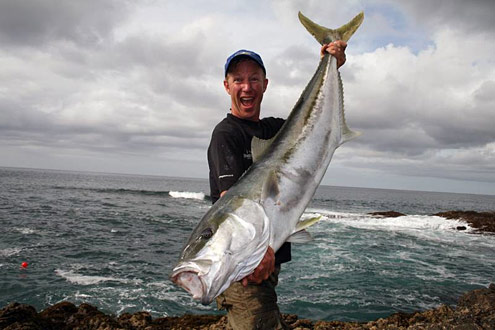

In [10]:
Image('data/mf.jpg')

In [11]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
model = resnet50(pretrained=True)
model.avgpool = nn.AdaptiveAvgPool2d((1, 1))
model.fc = nn.Linear(2048, len(train_dataset.classes))
model.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
# freeze layers by not tracking gradients
for param in model.parameters():
    param.requires_grad = False

model.fc.weight.requires_grad = True # unfreeze last layer weights
model.fc.bias.requires_grad = True # unfreeze last layer biases

optimiser = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4
) #only optimise non-frozen layers

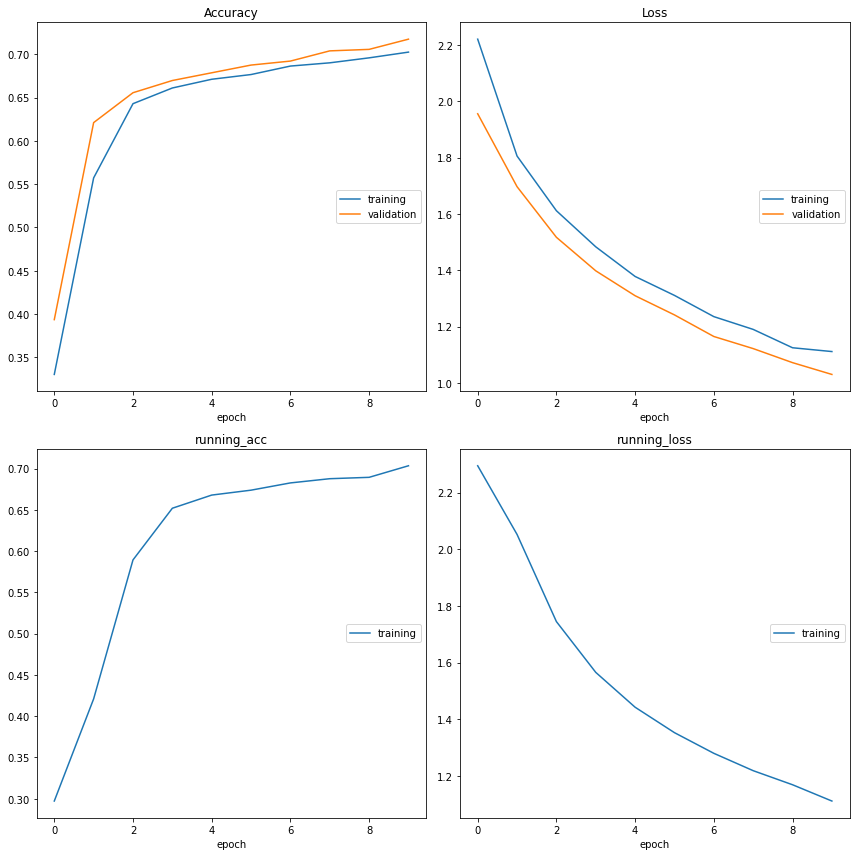

Wall time: 3min 55s


In [12]:
%%time

loss_function = nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trial = Trial(model, optimiser, loss_function,
              metrics=['loss', 'accuracy'],
              callbacks=[LiveLossPlot()]).to(device)
trial.with_generators(train_loader, 
                      val_generator=val_loader,
                      test_generator=test_loader)
history = trial.run(epochs=10)

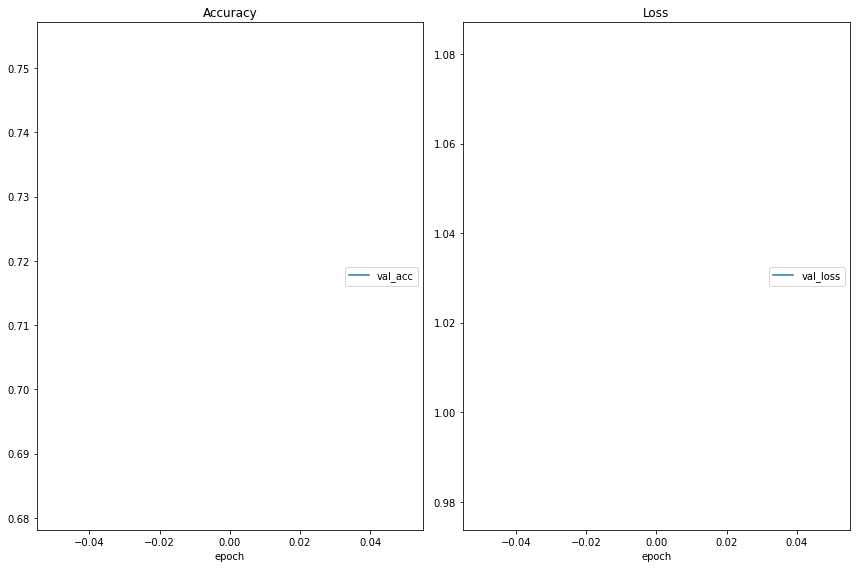


{'val_loss': 1.0304067134857178, 'val_acc': 0.717616617679596}


In [13]:
results = trial.evaluate(data_key=torchbearer.VALIDATION_DATA)
print()
print(results)

## Extracting Features from a Model

In [3]:
from torch import nn

In [5]:
model = resnet50(pretrained=True)
feature_extractor_model = nn.Sequential(*list(model.children())[:-2],
                                        nn.AdaptiveAvgPool2d((1, 1)))
feature_extractor_model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
feature_extractor_model = feature_extractor_model.to(device)

In [11]:
transform = transforms.Compose([
    transforms.Resize((240, 800)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])

img_path = 'data/test/Alilaguna/20130412_064059_20202.jpg'
img = PImage.open(img_path)
feature = feature_extractor_model(transform(img).unsqueeze(0).to(device))
print('Feature shape:', feature.shape)
print('Feature data:', feature[0].reshape(-1))

Feature shape: torch.Size([1, 2048, 1, 1])
Feature data: tensor([0.1663, 0.1870, 0.0875,  ..., 0.0632, 0.4124, 0.1825], device='cuda:0',
       grad_fn=<ViewBackward>)


In [13]:
img_path_2 = 'data/test/Polizia/20130412_064127_20371.jpg'
img_2 = PImage.open(img_path_2)
feature_2 = feature_extractor_model(transform(img_2).unsqueeze(0).to(device))
print('Feature shape:', feature_2.shape)
print('Feature data:', feature_2[0].reshape(-1))

Feature shape: torch.Size([1, 2048, 1, 1])
Feature data: tensor([0.1016, 0.0868, 0.0670,  ..., 0.0484, 0.2239, 0.0385], device='cuda:0',
       grad_fn=<ViewBackward>)


In [14]:
# euclidian distance between two feature vectors
dist_vect = torch.dist(feature, feature_2, 2)
print('distance:', dist_vect)

distance: tensor(7.5243, device='cuda:0', grad_fn=<DistBackward>)


Euclidean distance: 7.52425479888916


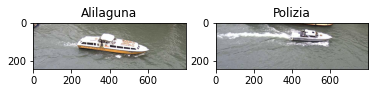

In [15]:
# distance for very different boats
print('Euclidean distance:', dist_vect.cpu().item())

plt.subplot(221).set_title('Alilaguna')
plt.imshow(img)

plt.subplot(222).set_title('Polizia')
plt.imshow(img_2)

Euclidean distance: 0.0


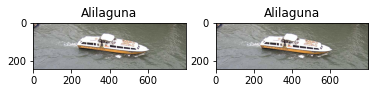

In [16]:
# distance for identical image
print('Euclidean distance:', torch.dist(feature, feature).cpu().item())

plt.subplot(221).set_title('Alilaguna')
plt.imshow(img)

plt.subplot(222).set_title('Alilaguna')
plt.imshow(img)

Euclidean distance: 8.433279037475586


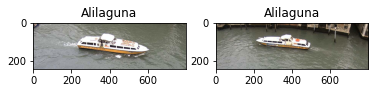

In [18]:
# distance for similar boat
img_path_3 = 'data/test/Alilaguna/20130412_064800_22567.jpg'
img_3 = PImage.open(img_path_3)
feature_3 = feature_extractor_model(transform(img_3).unsqueeze(0).to(device))
print('Euclidean distance:', torch.dist(feature, feature_3, 2).cpu().item())

plt.subplot(221).set_title('Alilaguna')
plt.imshow(img)

plt.subplot(222).set_title('Alilaguna')
plt.imshow(img_3)

The distance = 0 for identical images as expected. And the distance was high for two different types of boats, also as expected. However, for the same boat captured in two different orientation, the distance was unexpectedly close to the distance of pictures of two different types of boats.

Actually, using the new transform, the same boat in different orientation has a greater distance that images of two completely different boats.

## Using ResNet with SVM

In [19]:
import numpy as np

In [20]:
import wget
from os.path import exists

if not exists('training_features.npy'):
    url = 'https://artist-cloud.ecs.soton.ac.uk/index.php/s/P68OB07DquOwSR7/download'
    filename = wget.download(url, out='Resnet50Features.zip')
    
import zipfile

with zipfile.ZipFile('Resnet50Features.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [21]:
training_features = np.load('training_features.npy')
training_labels = np.load('training_labels.npy')

valid_features = np.load('valid_features.npy')
valid_labels = np.load('valid_labels.npy')

testing_features = np.load('testing_features.npy')
testing_labels = np.load('testing_labels.npy')

In [22]:
from sklearn.svm import SVC

In [23]:
clf = SVC(decision_function_shape='ovr')
clf.fit(training_features, training_labels)

SVC()

In [24]:
valid_predictions = clf.predict(valid_features)

In [25]:
from sklearn.metrics import classification_report

In [26]:
from pathlib import Path

p = Path('./data/valid/')

target_names = [str(f).split('\\')[2] for f in p.iterdir() if f.is_dir()]

In [27]:
print(classification_report(valid_labels, 
                            valid_predictions, 
                            target_names=target_names))

                         precision    recall  f1-score   support

              Alilaguna       0.92      1.00      0.96        12
              Ambulanza       0.75      0.67      0.71         9
               Barchino       0.75      0.25      0.38        12
                Gondola       0.67      0.67      0.67         3
          Lanciafino10m       0.00      0.00      0.00         3
              Motobarca       0.50      0.09      0.15        22
Motopontonerettangolare       1.00      1.00      1.00         2
          MotoscafoACTV       0.00      0.00      0.00         2
               Mototopo       0.67      0.98      0.80        88
              Patanella       0.57      0.82      0.68        28
                Polizia       0.50      0.12      0.20         8
        Raccoltarifiuti       1.00      0.40      0.57        10
           Sandoloaremi       0.00      0.00      0.00         2
                   Topa       0.00      0.00      0.00         8
          VaporettoACTV 

C:\Users\Eleni\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


A system with high recall but low precision returns many results, but most of its predicted labels are incorrect when compared to the training labels.

A system with high precision but low recall is just the opposite, returning very few results, but most of its predicted labels are correct when compared to the training labels.

An ideal system with high precision and high recall will return many results, with all results labeled correctly.

In [42]:
# grid search to optimise hyperparams
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        SVC(), tuned_parameters, scoring='%s_macro' % score
    )
    clf.fit(training_features, training_labels)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = valid_labels, clf.predict(valid_features)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision



C:\Users\Eleni\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Eleni\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Eleni\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Eleni\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedM

C:\Users\Eleni\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Eleni\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Eleni\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Eleni\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedM

Best parameters set found on development set:

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.246 (+/-0.008) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.150 (+/-0.001) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.751 (+/-0.084) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.247 (+/-0.008) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.852 (+/-0.061) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.758 (+/-0.093) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.846 (+/-0.057) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.841 (+/-0.057) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.827 (+/-0.071) for {'C': 1, 'kernel': 'linear'}
0.828 (+/-0.071) for {'C': 10, 'kernel': 'linear'}
0.828 (+/-0.071) for {'C': 100, 'kernel': 'linear'}
0.828 (+/-0.071) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

            

In [52]:
clf = SVC(random_state=55)
clf.fit(training_features, training_labels)

SVC(random_state=55)

In [53]:
y_true, y_pred = valid_labels, clf.predict(valid_features)
print(classification_report(valid_labels, 
                            valid_predictions, 
                            target_names=target_names))

                         precision    recall  f1-score   support

              Alilaguna       0.92      1.00      0.96        12
              Ambulanza       0.75      0.67      0.71         9
               Barchino       0.75      0.25      0.38        12
                Gondola       0.67      0.67      0.67         3
          Lanciafino10m       0.00      0.00      0.00         3
              Motobarca       0.50      0.09      0.15        22
Motopontonerettangolare       1.00      1.00      1.00         2
          MotoscafoACTV       0.00      0.00      0.00         2
               Mototopo       0.67      0.98      0.80        88
              Patanella       0.57      0.82      0.68        28
                Polizia       0.50      0.12      0.20         8
        Raccoltarifiuti       1.00      0.40      0.57        10
           Sandoloaremi       0.00      0.00      0.00         2
                   Topa       0.00      0.00      0.00         8
          VaporettoACTV 

C:\Users\Eleni\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
